In [1]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns
import plotly.graph_objects as go
import plotly.graph_objects as go
from sktime.forecasting.model_selection import temporal_train_test_split
from tabulate import tabulate

%matplotlib inline

import warnings
import datetime

warnings.filterwarnings("ignore")

In [2]:
huwaei=pd.read_csv('training_100.csv')
cols=[i for i in huwaei.columns if i not in ['timestamp']]
for col in cols:
    huwaei[col]=pd.to_numeric(huwaei[col])
huwaei['timestamp'] = pd.to_datetime(huwaei['timestamp'])

huwaei.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20159 entries, 0 to 20158
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype                                
---  ------         --------------  -----                                
 0   timestamp      20159 non-null  datetime64[ns, pytz.FixedOffset(120)]
 1   kpi_value      20159 non-null  float64                              
 2   request_count  20159 non-null  int64                                
 3   anomaly_label  20159 non-null  int64                                
dtypes: datetime64[ns, pytz.FixedOffset(120)](1), float64(1), int64(2)
memory usage: 630.1 KB


In [3]:
huwaei['hour'] = huwaei['timestamp'].dt.hour
huwaei['minute'] = huwaei['timestamp'].dt.minute
huwaei

,timestamp,kpi_value,request_count,anomaly_label,hour,minute
0,2020-08-14 02:00:00+02:00,0.998755,24908,0,2,0
1,2020-08-14 02:01:00+02:00,0.997683,25029,0,2,1
2,2020-08-14 02:02:00+02:00,0.998341,24115,0,2,2
3,2020-08-14 02:03:00+02:00,0.998211,24031,0,2,3
4,2020-08-14 02:04:00+02:00,0.998403,23790,0,2,4
...,...,...,...,...,...,...
20154,2020-08-28 01:56:00+02:00,0.998149,26467,0,1,56
20155,2020-08-28 01:57:00+02:00,0.998340,26502,0,1,57
20156,2020-08-28 01:58:00+02:00,0.998364,26887,0,1,58
20157,2020-08-28 01:59:00+02:00,0.998428,26712,0,1,59


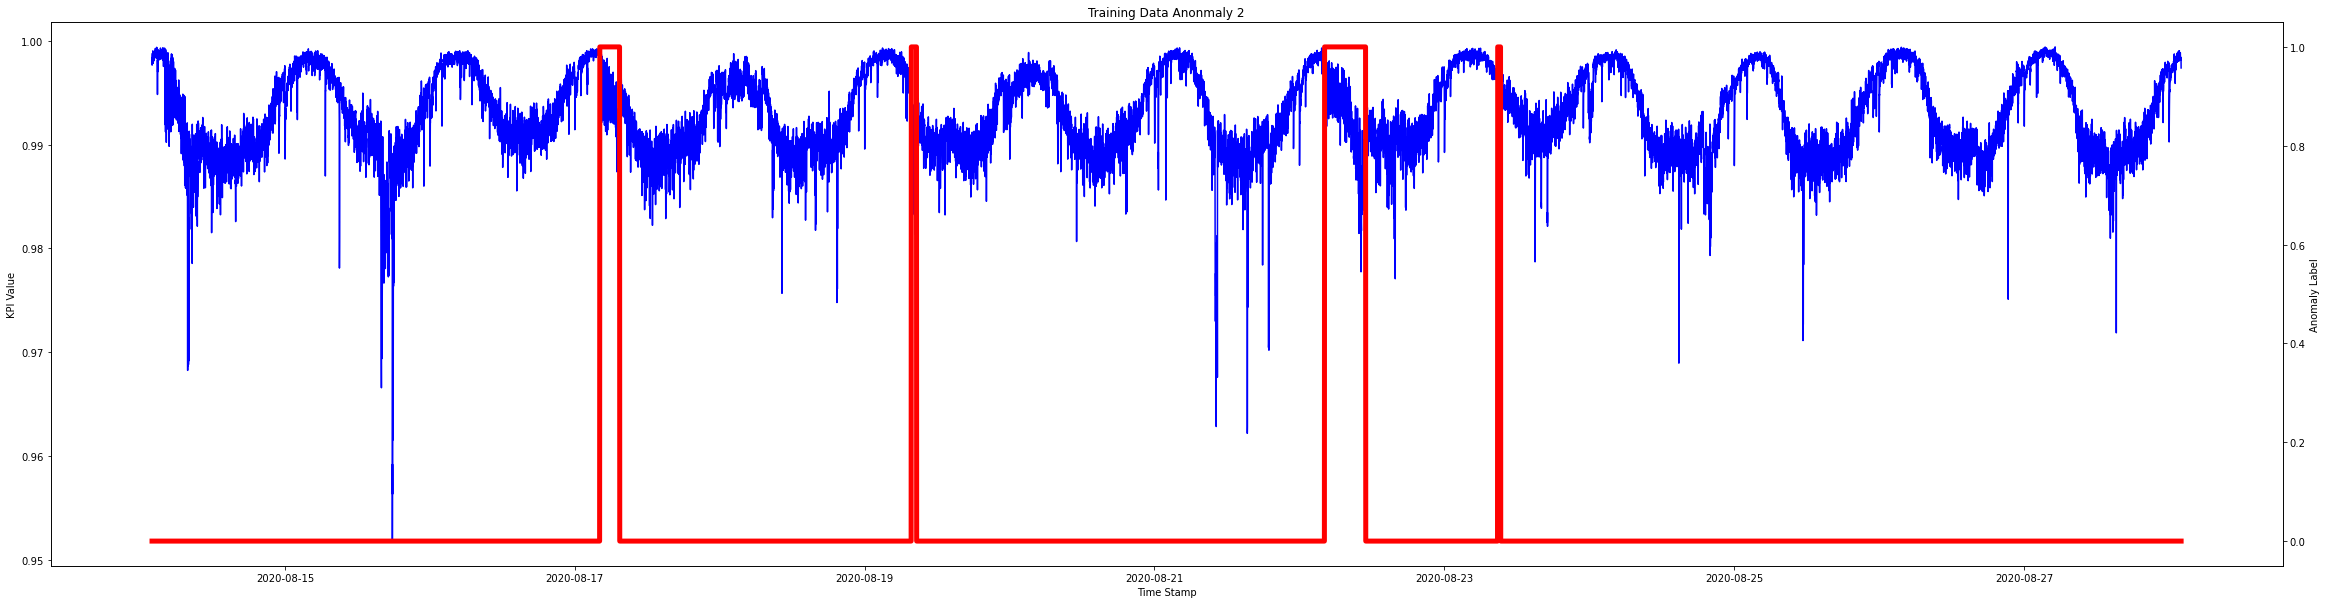

In [4]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(huwaei['timestamp'], huwaei['kpi_value'], color='blue')
ax2a.plot(huwaei['timestamp'], huwaei['anomaly_label'], color='red', linewidth='5')
ax2d.set_xlabel('Time Stamp')
ax2d.set_ylabel('KPI Value')
ax2a.set_ylabel('Anomaly Label')
ax2d.title.set_text('Training Data Anonmaly 2')

# Huwaei

In [5]:
huwaei_dataset=huwaei[['timestamp', 'kpi_value', 'hour', 'minute']]
#dataset

# convert the column (it's a string) to datetime type
datetime_series = pd.to_datetime(huwaei_dataset['timestamp'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

# datetime_index
period_index = pd.PeriodIndex(datetime_index, freq='S')

# period_index
huwaei_dataset = huwaei_dataset.set_index(period_index)

# we don't need the column anymore
huwaei_dataset.drop('timestamp',axis=1,inplace=True)

huwaei_dataset.head()
# print(len(dataset))

,kpi_value,hour,minute
2020-08-14 00:00:00,0.998755,2,0
2020-08-14 00:01:00,0.997683,2,1
2020-08-14 00:02:00,0.998341,2,2
2020-08-14 00:03:00,0.998211,2,3
2020-08-14 00:04:00,0.998403,2,4


In [6]:
start=1
finish=30
increments=0.100
increments=int(1/increments)
# print(increments)

contamination=(np.linspace(start, finish ,finish*increments))/100

# importing the isloation forest
from sklearn.neighbors import LocalOutlierFactor

anomalies=[]
for i in contamination:
    # copying dataset
    isf_dataset = huwaei_dataset.copy()

    # initializing Isolation Forest
    clf = LocalOutlierFactor(n_neighbors=10, contamination=i)

    # training
    clf.fit(isf_dataset)

    # finding anomalies
    isf_dataset['Anomaly'] = clf.fit_predict(isf_dataset) 

    # saving anomalies to a separate dataset for visualization purposes
    # anomalies_single = isf_dataset.query('Anomaly == -1')
    anomalies.append(isf_dataset)

In [7]:
total_contamination=len(anomalies)

In [8]:
output=anomalies

In [9]:
True_Positives=[]
False_Positives=[]
True_Negatives=[]
False_Negatives=[]
for j in range(total_contamination):
    TP_single=0
    FP_single=0
    TN_single=0
    FN_single=0
    for i in range(len(output[j]['Anomaly'])):
        if output[j]['Anomaly'].iloc[i] == -1 and huwaei['anomaly_label'].iloc[i] == 1:
            TP_single=TP_single+1
        elif output[j]['Anomaly'].iloc[i] == -1 and huwaei['anomaly_label'].iloc[i] != 1:
            FP_single=FP_single+1
        elif output[j]['Anomaly'].iloc[i] != -1 and huwaei['anomaly_label'].iloc[i] == 1:
            FN_single=FN_single+1
        elif output[j]['Anomaly'].iloc[i] != -1 and huwaei['anomaly_label'].iloc[i] != 1:
            TN_single=TN_single+1
    True_Positives.append(TP_single)
    False_Positives.append(FP_single)
    True_Negatives.append(TN_single)
    False_Negatives.append(FN_single)

In [10]:
tp=np.array(True_Positives)
fp=np.array(False_Positives)
tn=np.array(True_Negatives)
fn=np.array(False_Negatives)

precision=tp/(tp+fp)
recall=tp/(tp+fn)

F1_Score=(2*precision*recall)/(precision+recall)

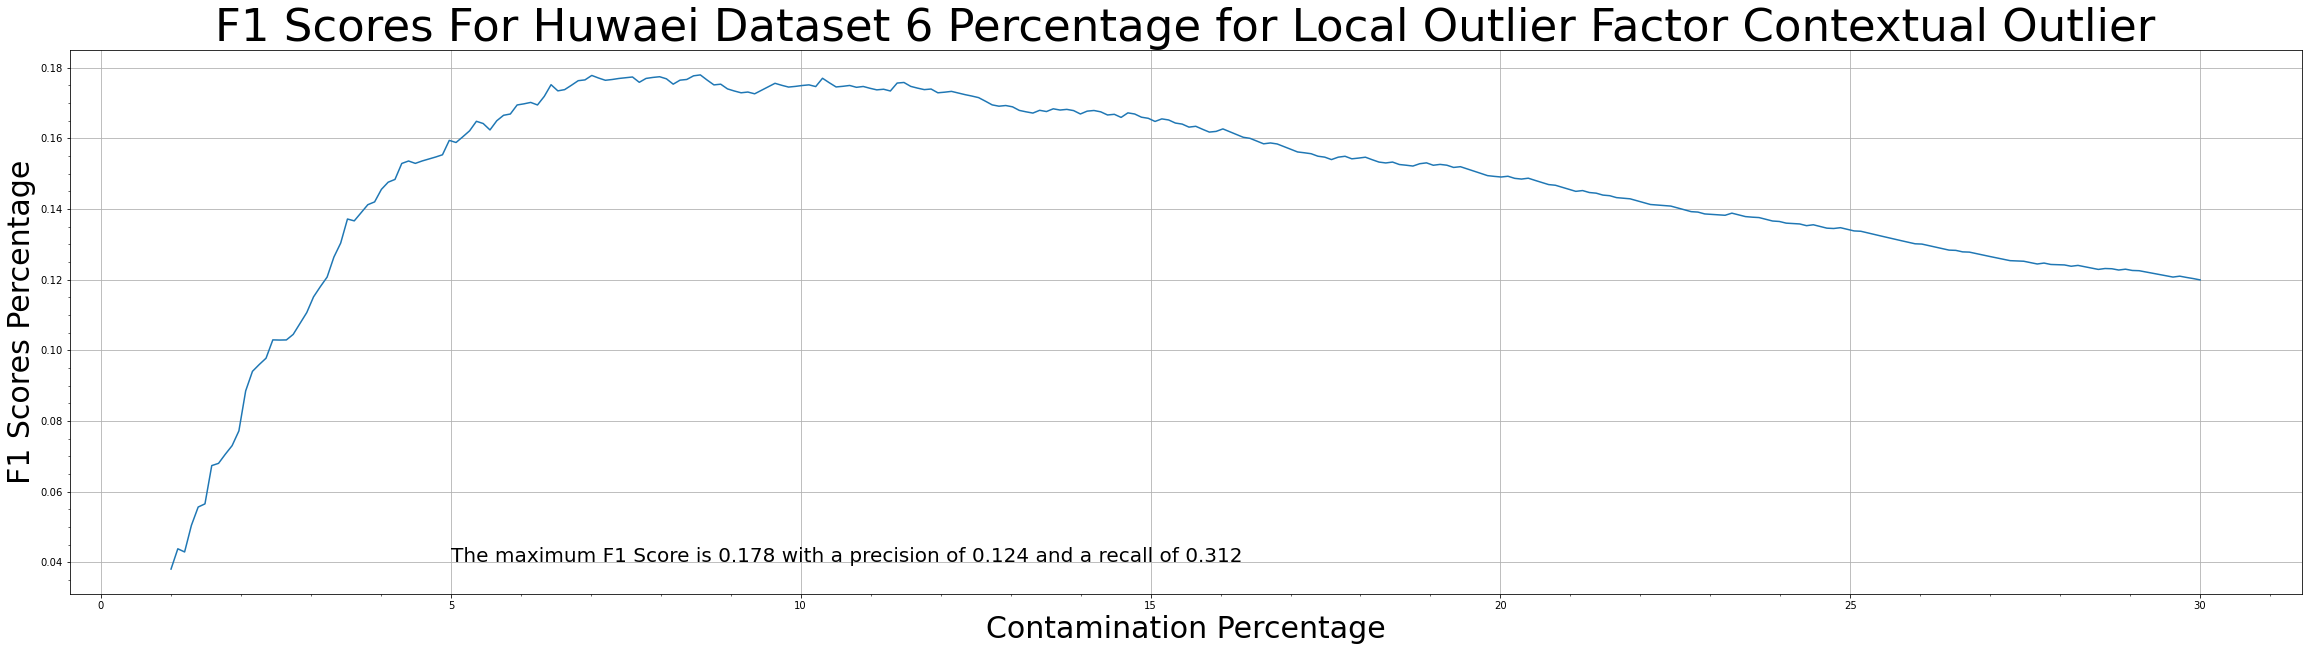

In [15]:
plt.figure(figsize=(40,10))
plt.title("F1 Scores For Huwaei Dataset 6 Percentage for Local Outlier Factor Contextual Outlier", fontsize=45)
plt.xlabel("Contamination Percentage", fontsize=30)
plt.ylabel("F1 Scores Percentage", fontsize=30)
plt.plot(contamination*100, F1_Score)

plt.minorticks_on()
plt.grid()
#To show where the contamination is at the maximum F1 Score
big=F1_Score.max()
big

plt.text(5, 0.04, f"The maximum F1 Score is {round(big,3)} with a precision of {round(precision[78],3)} and a recall of {round(recall[78],3)}", fontsize=20);

plt.savefig('F1 Scores For Huwaei Dataset 6 Percentage for Local Outlier Factor Contextual Outlier.png') 

In [12]:
arr=np.where(F1_Score==big)
print(arr[0])

[78]


In [13]:
print(f"Contamination at max F_{1} Score: {round(contamination[int(arr[0])],5)*100}%")
print("")
print(f"Precision: {round(precision[int(arr[0])],3)}")
print(f"Recall: {round(recall[int(arr[0])],3)}")
print(f"F1 Score: {round(big,3)}")

Contamination at max F_1 Score: 8.565000000000001%

Precision: 0.124
Recall: 0.312
F1 Score: 0.178
